### Libraries

In [1]:
import sys, os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from utils.EDA import vis_numeric_corr_matrix

In [2]:
load_dotenv()
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

In [3]:
TRAIN_PATH = os.getenv('TRAIN_DATA_PATH')
TEST_PATH = os.getenv('TEST_DATA_PATH')

train = pd.read_csv(TRAIN_PATH).drop(columns=['ID'])
test = pd.read_csv(TEST_PATH)
# vis_numeric_corr_matrix(train) #<--- for visualizing corr matrix
print(f"Column 일치 여부 : {train.columns.values.tolist()[:-1] == test.columns.values.tolist()}")
print(f"Train Row 수 :{len(train)}")
print(f"Test Row 수 :{len(test)}")
train.info()

Column 일치 여부 : False
Train Row 수 :256351
Test Row 수 :90067
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술 시기 코드               256351 non-null  object 
 1   시술 당시 나이               256351 non-null  object 
 2   임신 시도 또는 마지막 임신 경과 연수  9370 non-null    float64
 3   시술 유형                  256351 non-null  object 
 4   특정 시술 유형               256349 non-null  object 
 5   배란 자극 여부               256351 non-null  int64  
 6   배란 유도 유형               256351 non-null  object 
 7   단일 배아 이식 여부            250060 non-null  float64
 8   착상 전 유전 검사 사용 여부       2718 non-null    float64
 9   착상 전 유전 진단 사용 여부       250060 non-null  float64
 10  남성 주 불임 원인             256351 non-null  int64  
 11  남성 부 불임 원인             256351 non-null  int64  
 12  여성 주 불임 원인             256351 non-null  int64  
 13  여성 부 불임 원인             256351 

### Preprocessing

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()


import pandas as pd 
from sklearn.preprocessing import LabelEncoder

def get_feature(df, validation: bool):
    """
    Get the feature columns from the dataframe
    """
    columns_str = df.columns.to_list()
    
    if columns_str:
        columns_list = [col.strip() for col in columns_str.split(",")]
    
    # 임신 성공 여부 제거
    if validation:
        columns_list.remove('임신 성공 여부')

    return df[columns_list]

def preprocess(train:pd.DataFrame, validation = False):
    #%% SETTING
    le = LabelEncoder()
    
    #%% 시술 시기 코드
    train['시술 시기 코드'] = le.fit_transform(train['시술 시기 코드'])
    
    #%% 시술 당시 나이
    train['시술 당시 나이'] = train['시술 당시 나이'].map({
    '만18-34세': 0,
    '만35-37세': 1,
    '만38-39세': 2,
    '만40-42세': 3,
    '만43-44세': 4,
    '만45-50세': 5,
    '알 수 없음' : 999
    })
    
    #%% 임신 시도 또는 마지막 임신 경과 연수
    train['임신 시도 또는 마지막 임신 경과 연수'] = train['임신 시도 또는 마지막 임신 경과 연수'].fillna(999)
    
    #%% 시술 유형
    train['시술 유형'] = le.fit_transform(train['시술 유형']) # Label Encoder

    train['특정 시술 유형'] = train['특정 시술 유형'].fillna('0')
    train['특정 시술 유형'] = le.fit_transform(train['특정 시술 유형'])
    
    #%% 배란 유도 유형
    # 배란 유도 유형에서 세트로타이드, 생식선 자극 호르몬 제거  -> 소수 데이터 sampling
    train = train[train['배란 유도 유형'] != '세트로타이드 (억제제)']
    train = train[train['배란 유도 유형'] != '생식선 자극 호르몬']

    # 기록되지 않은 시행 -> 1 / 알 수 없음 -> 0
    train['배란 유도 유형'] = train['배란 유도 유형'].map({
        '기록되지 않은 시행' : 1,
        '알 수 없음' : 0
    })

    #%% 단일 배아 이식 여부
    train['단일 배아 이식 여부'] = train['단일 배아 이식 여부'].fillna(0)
    
    #%% 착상 전 유전 검사 사용 여부
    train['착상 전 유전 검사 사용 여부'] = train['착상 전 유전 검사 사용 여부'].fillna(0)
    
    #%% 착상 전 유전 진단 사용 여부
    train['착상 전 유전 진단 사용 여부'] = train['착상 전 유전 진단 사용 여부'].fillna(999) # -> 
    
    #%% 배아 생성 주요 이유
    train['배아 생성 주요 이유'] = train['배아 생성 주요 이유'].fillna('0')

    train['배아 생성 주요 이유'] = train['배아 생성 주요 이유'].str.split(',')
    train = train.explode('배아 생성 주요 이유') # 여러 행 분리 
    train['배아 생성 주요 이유'] = train['배아 생성 주요 이유'].str.strip() # 좌우 공백 제거

    train['배아 생성 주요 이유'] = le.fit_transform(train['배아 생성 주요 이유'])
    
    #%% 총 시술 횟수
    train['총 시술 횟수'] = train['총 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% 클리닉 내 총 시술 횟수
    train['클리닉 내 총 시술 횟수'] = train['클리닉 내 총 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    #%% IVF 시술 횟수
    train['IVF 시술 횟수'] = train['IVF 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% DI 시술 횟수
    train['DI 시술 횟수'] = train['DI 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% 총 임신 횟수
    train['총 임신 횟수'] = train['총 임신 횟수'].fillna('0회')
    train['총 임신 횟수'] = train['총 임신 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% IVF 임신 횟수 
    train['IVF 임신 횟수'] = train['IVF 임신 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    #%% DI 임신 횟수
    train['DI 임신 횟수'] = train['DI 임신 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    #%% 총 출산 횟수
    train['총 출산 횟수'] = train['총 출산 횟수'].fillna('0회')
    train['총 출산 횟수'] = train['총 출산 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    
    #%% IVF 출산 횟수
    train['IVF 출산 횟수'] = train['IVF 출산 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    
    #%% DI 출산 횟수
    train['DI 출산 횟수'] = train['DI 출산 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    
    #%% 총 생성 배아 수
    train['총 생성 배아 수'] = train['총 생성 배아 수'].fillna(999)

    #%% 미세주입된 난자 수 
    train['미세주입된 난자 수'] = train['미세주입된 난자 수'].fillna(999)
    
    #%% 미세주입에서 생성된 배아 수 
    train['미세주입에서 생성된 배아 수'] = train['미세주입에서 생성된 배아 수'].fillna(999)

    #%% 이식된 배아 수
    train['이식된 배아 수'] = train['이식된 배아 수'].fillna(999)

    #%% 이식된 배아 수
    train['저장된 배아 수'] = train['저장된 배아 수'].fillna(999)
    
    #%% 미세주입 배아 이식 수 
    train['미세주입 배아 이식 수'] = train['미세주입 배아 이식 수'].fillna(999)

    #%% 미세주입 후 저장된 배아 수 
    train['미세주입 후 저장된 배아 수'] = train['미세주입 후 저장된 배아 수'].fillna(999)

    #%% 혼합된 난자 수
    train['혼합된 난자 수'] = train['혼합된 난자 수'].fillna(999)

    #%% 파트너 정자와 혼합된 난자 수
    train['파트너 정자와 혼합된 난자 수'] = train['파트너 정자와 혼합된 난자 수'].fillna(999)
    
    #%% 기증자 정자와 혼합된 난자 수 -> 6291개는 제거하는게 좋을 것 같음
    # if not validation:
    #     train = train[train['기증자 정자와 혼합된 난자 수'].notnull()]
    
    #%% 난자정자 출처
    train['난자 출처'] = le.fit_transform(train['난자 출처'])
    train['정자 출처'] = le.fit_transform(train['정자 출처'])
    #%% 난자 기증자 나이
    train['난자 기증자 나이'] = train['난자 기증자 나이'].map({
        '알 수 없음' : 999,
        '만20세 이하' : 0,
        '만21-25세' : 1,
        '만26-30세' : 2,
        '만31-35세' : 3,
    })
    
    #%% 정자 기증자 나이
    train['정자 기증자 나이'] = train['정자 기증자 나이'].map({
        '알 수 없음' : 999,
        '만20세 이하' : 0,
        '만21-25세' : 1,
        '만26-30세' : 2,
        '만31-35세' : 3,
        '만36-40세' : 4,
        '만41-45세' : 5,
    })
    
    # %% 난자 채취 경과일
    train['난자 채취 경과일'] = train['난자 채취 경과일'].fillna(999)
    
    #%% 동결 배아 사용 여부
    train['동결 배아 사용 여부'] = train['동결 배아 사용 여부'].fillna(999)
    
    #%% 신선 배아 사용 여부
    train['신선 배아 사용 여부'] = train['신선 배아 사용 여부'].fillna(999)

    #%% 난자 해동 경과일
    train['난자 해동 경과일'] = train['난자 해동 경과일'].fillna(999)
    
    #%% 난자 혼합 경과일
    train['난자 혼합 경과일'] = train['난자 혼합 경과일'].fillna(999)
    
    #%% 배아 이식 경과일 
    train['배아 이식 경과일'] = train['배아 이식 경과일'].fillna(999)

    #%% 배아 해동 경과일 
    train['배아 해동 경과일'] = train['배아 해동 경과일'].fillna(999)

    #%% 해동된 배아 수
    train['해동된 배아 수'] = train['해동된 배아 수'].fillna(999)

    #%% 해동된 난자 수
    train['해동 난자 수'] = train['해동 난자 수'].fillna(999)

    #%% 저장된 신선 난자 수
    train['저장된 신선 난자 수'] = train['저장된 신선 난자 수'].fillna(999)

    #%% 수집된 신선 난자 수
    train['수집된 신선 난자 수'] = train['수집된 신선 난자 수'].fillna(999)

    #%% 기증자 정자와 혼합된 난자 수
    train['기증자 정자와 혼합된 난자 수'] = train['기증자 정자와 혼합된 난자 수'].fillna(999)

    #%% 기증 배아 사용 여부
    train['기증 배아 사용 여부'] = train['기증 배아 사용 여부'].fillna(0)
    
    # #%% PGD 시술 여부 Nan -> 0으로 처리
    train['PGD 시술 여부'] = train['PGD 시술 여부'].fillna(0)

    # #%% PGD 시술 여부 Nan -> 0으로 처리
    train['PGS 시술 여부'] = train['PGS 시술 여부'].fillna(0)
    
    # #%% 대리모 여부 Nan -> 0으로 처리
    train['대리모 여부'] = train['대리모 여부'].fillna(0)
    
    # 모두 0 처리
    train = train.drop(columns = '불임 원인 - 여성 요인')
    
    

    return train

In [5]:
from utils.feature import preprocess
pre_train = preprocess(train = train)
pre_test = preprocess(train = test, validation= True)

In [6]:
# 결측 비율 확인
pre_train.isnull().mean(), pre_test.isnull().mean()

(시술 시기 코드                 0.0
 시술 당시 나이                 0.0
 임신 시도 또는 마지막 임신 경과 연수    0.0
 시술 유형                    0.0
 특정 시술 유형                 0.0
                         ... 
 난자 해동 경과일                0.0
 난자 혼합 경과일                0.0
 배아 이식 경과일                0.0
 배아 해동 경과일                0.0
 임신 성공 여부                 0.0
 Length: 67, dtype: float64,
 ID                       0.0
 시술 시기 코드                 0.0
 시술 당시 나이                 0.0
 임신 시도 또는 마지막 임신 경과 연수    0.0
 시술 유형                    0.0
                         ... 
 난자 채취 경과일                0.0
 난자 해동 경과일                0.0
 난자 혼합 경과일                0.0
 배아 이식 경과일                0.0
 배아 해동 경과일                0.0
 Length: 67, dtype: float64)

### Feature engineering

In [7]:
import pandas as pd

def feature_engineering(df):

    # -------------------------
    # 1. 시술 정보 관련 변수
    # -------------------------
    # 기본 정보
    # df['나이 대비 임신 확률'] = df['총 임신 횟수'] / df['시술 당시 나이']
    # df['나이 대비 임신 시도 기간'] = df['임신 시도 또는 마지막 임신 경과 연수'] / df['시술 당시 나이']

    # 시술 횟수 관련 변수
    # df['총 임신 성공률'] = df['총 임신 횟수'] / df['총 시술 횟수']
    # df['IVF 임신 성공률'] = df['IVF 임신 횟수'] / df['IVF 시술 횟수']
    # df['시술당 평균 배아 생성 수'] = df['총 생성 배아 수'] / df['총 시술 횟수']
    # df['시술당 평균 이식 배아 수'] = df['이식된 배아 수'] / df['총 시술 횟수']
    df['시술 경험 점수'] = (df['총 시술 횟수'] + df['클리닉 내 총 시술 횟수']) / 2

    # -------------------------
    # 2. 임신 및 출산 정보 관련 변수
    # -------------------------
    # 임신 관련
    # df['임신 시도 대비 성공률'] = df['총 임신 횟수'] / (df['임신 시도 또는 마지막 임신 경과 연수'] + 1e-6)
    
    # 출산 관련
    # df['총 출산 성공률'] = df['총 출산 횟수'] / df['총 임신 횟수']
    df['IVF 출산 성공률'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1e-6)
    df['출산 유지율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1e-6)
    # df['출산-임신 성공률 차이'] = df['총 출산 성공률'] - df['총 임신 성공률']

    # -------------------------
    # 3. 배아 관련 정보 변수
    # -------------------------
    # 배아 생성 정보
    df['미세주입 배아 생성 확률'] = df['미세주입에서 생성된 배아 수'] / (df['미세주입된 난자 수'] + 1e-6)

    # 배아 이식 정보
    df['배아 이식 대비 최종 출산 성공률'] = df['총 출산 횟수'] / (df['이식된 배아 수'] + 1e-6)
    df['총 배아 이식 확률'] = df['이식된 배아 수'] / (df['총 생성 배아 수'] + 1e-6)
    df['미세주입 배아 이식 확률'] = df['미세주입 배아 이식 수'] / (df['미세주입에서 생성된 배아 수'] + 1e-6)
    
    # 배아 저장 및 해동 정보
    df['저장된 배아 사용률'] = df['이식된 배아 수'] / (df['저장된 배아 수'] + 1e-6)
    df['해동 배아 사용률'] = df['해동된 배아 수'] / (df['저장된 배아 수'] + 1e-6)
    df["배아 저장 대비 이식 기간"] = df["배아 이식 경과일"] / (df["저장된 배아 수"] + 1e-6)

    # -------------------------
    # 4. 난자 관련 정보 변수
    # -------------------------
    # 난자 수집 및 해동 정보
    df['난자 채취 대비 배아 생성 기간'] = df['배아 이식 경과일'] / (df['수집된 신선 난자 수'] + 1e-6)
    df['난자 혼합 비율'] = df['혼합된 난자 수'] / (df['수집된 신선 난자 수'] + 1e-6)

    # -------------------------
    # 5. 불임 원인 정보 변수
    # -------------------------
    # 불임 원인 다양성: 여러 불임 원인이 True인 개수

    # (추가 예시) 자궁내막증, 자궁경부 문제 등 여성 불임 세부 요인 점수
    # 해당 컬럼들이 존재한다고 가정
    if '불임 원인 - 자궁내막증' in df.columns and '불임 원인 - 자궁경부 문제' in df.columns:
        df['여성 불임 세부 지표'] = (
            df['불임 원인 - 자궁내막증'] * 1 +  # 가중치는 임의
            df['불임 원인 - 자궁경부 문제'] * 1
        )

    # (추가 예시) 정자 상태에 대한 세부 요인 점수
    # 해당 컬럼들이 존재한다고 가정
    if '불임 원인 - 정자 농도' in df.columns and '불임 원인 - 정자 운동성' in df.columns and '불임 원인 - 정자 형태' in df.columns:
        df['남성 정자 종합 지표'] = (
            df['불임 원인 - 정자 농도'] +
            df['불임 원인 - 정자 운동성'] +
            df['불임 원인 - 정자 형태']
            # 필요 시 각각에 다른 가중치 부여 가능
        )

    # -------------------------
    # 6. 기타 정보 변수
    # -------------------------

    # 착상 전 유전 검사/진단(PGS/PGD) 사용 여부 (True/False라고 가정)
    # 예: 사용하면 1, 아니면 0
    if '착상 전 유전 검사 사용 여부' in df.columns:
        df['PGS 사용'] = df['착상 전 유전 검사 사용 여부'].astype(int)
    if '착상 전 유전 진단 사용 여부' in df.columns:
        df['PGD 사용'] = df['착상 전 유전 진단 사용 여부'].astype(int)

    # -------------------------
    # 7. 배란 관련 정보
    # -------------------------

    # 배란 유도 유형이 범주형이라면 one-hot 인코딩 혹은 단순 라벨 인코딩
    if '배란 유도 유형' in df.columns:
        df = pd.get_dummies(df, columns=['배란 유도 유형'], prefix='배란유도')

    # -------------------------
    # 8. 시간 경과 관련 변수
    # -------------------------
    # df['난자 채취-이식 경과 비율'] = df['배아 이식 경과일'] / (df['난자 채취 경과일'] + 1e-6)
    # df['배아 해동 이후 이식 기간'] = df['배아 이식 경과일'] - df['배아 해동 경과일']

    return df

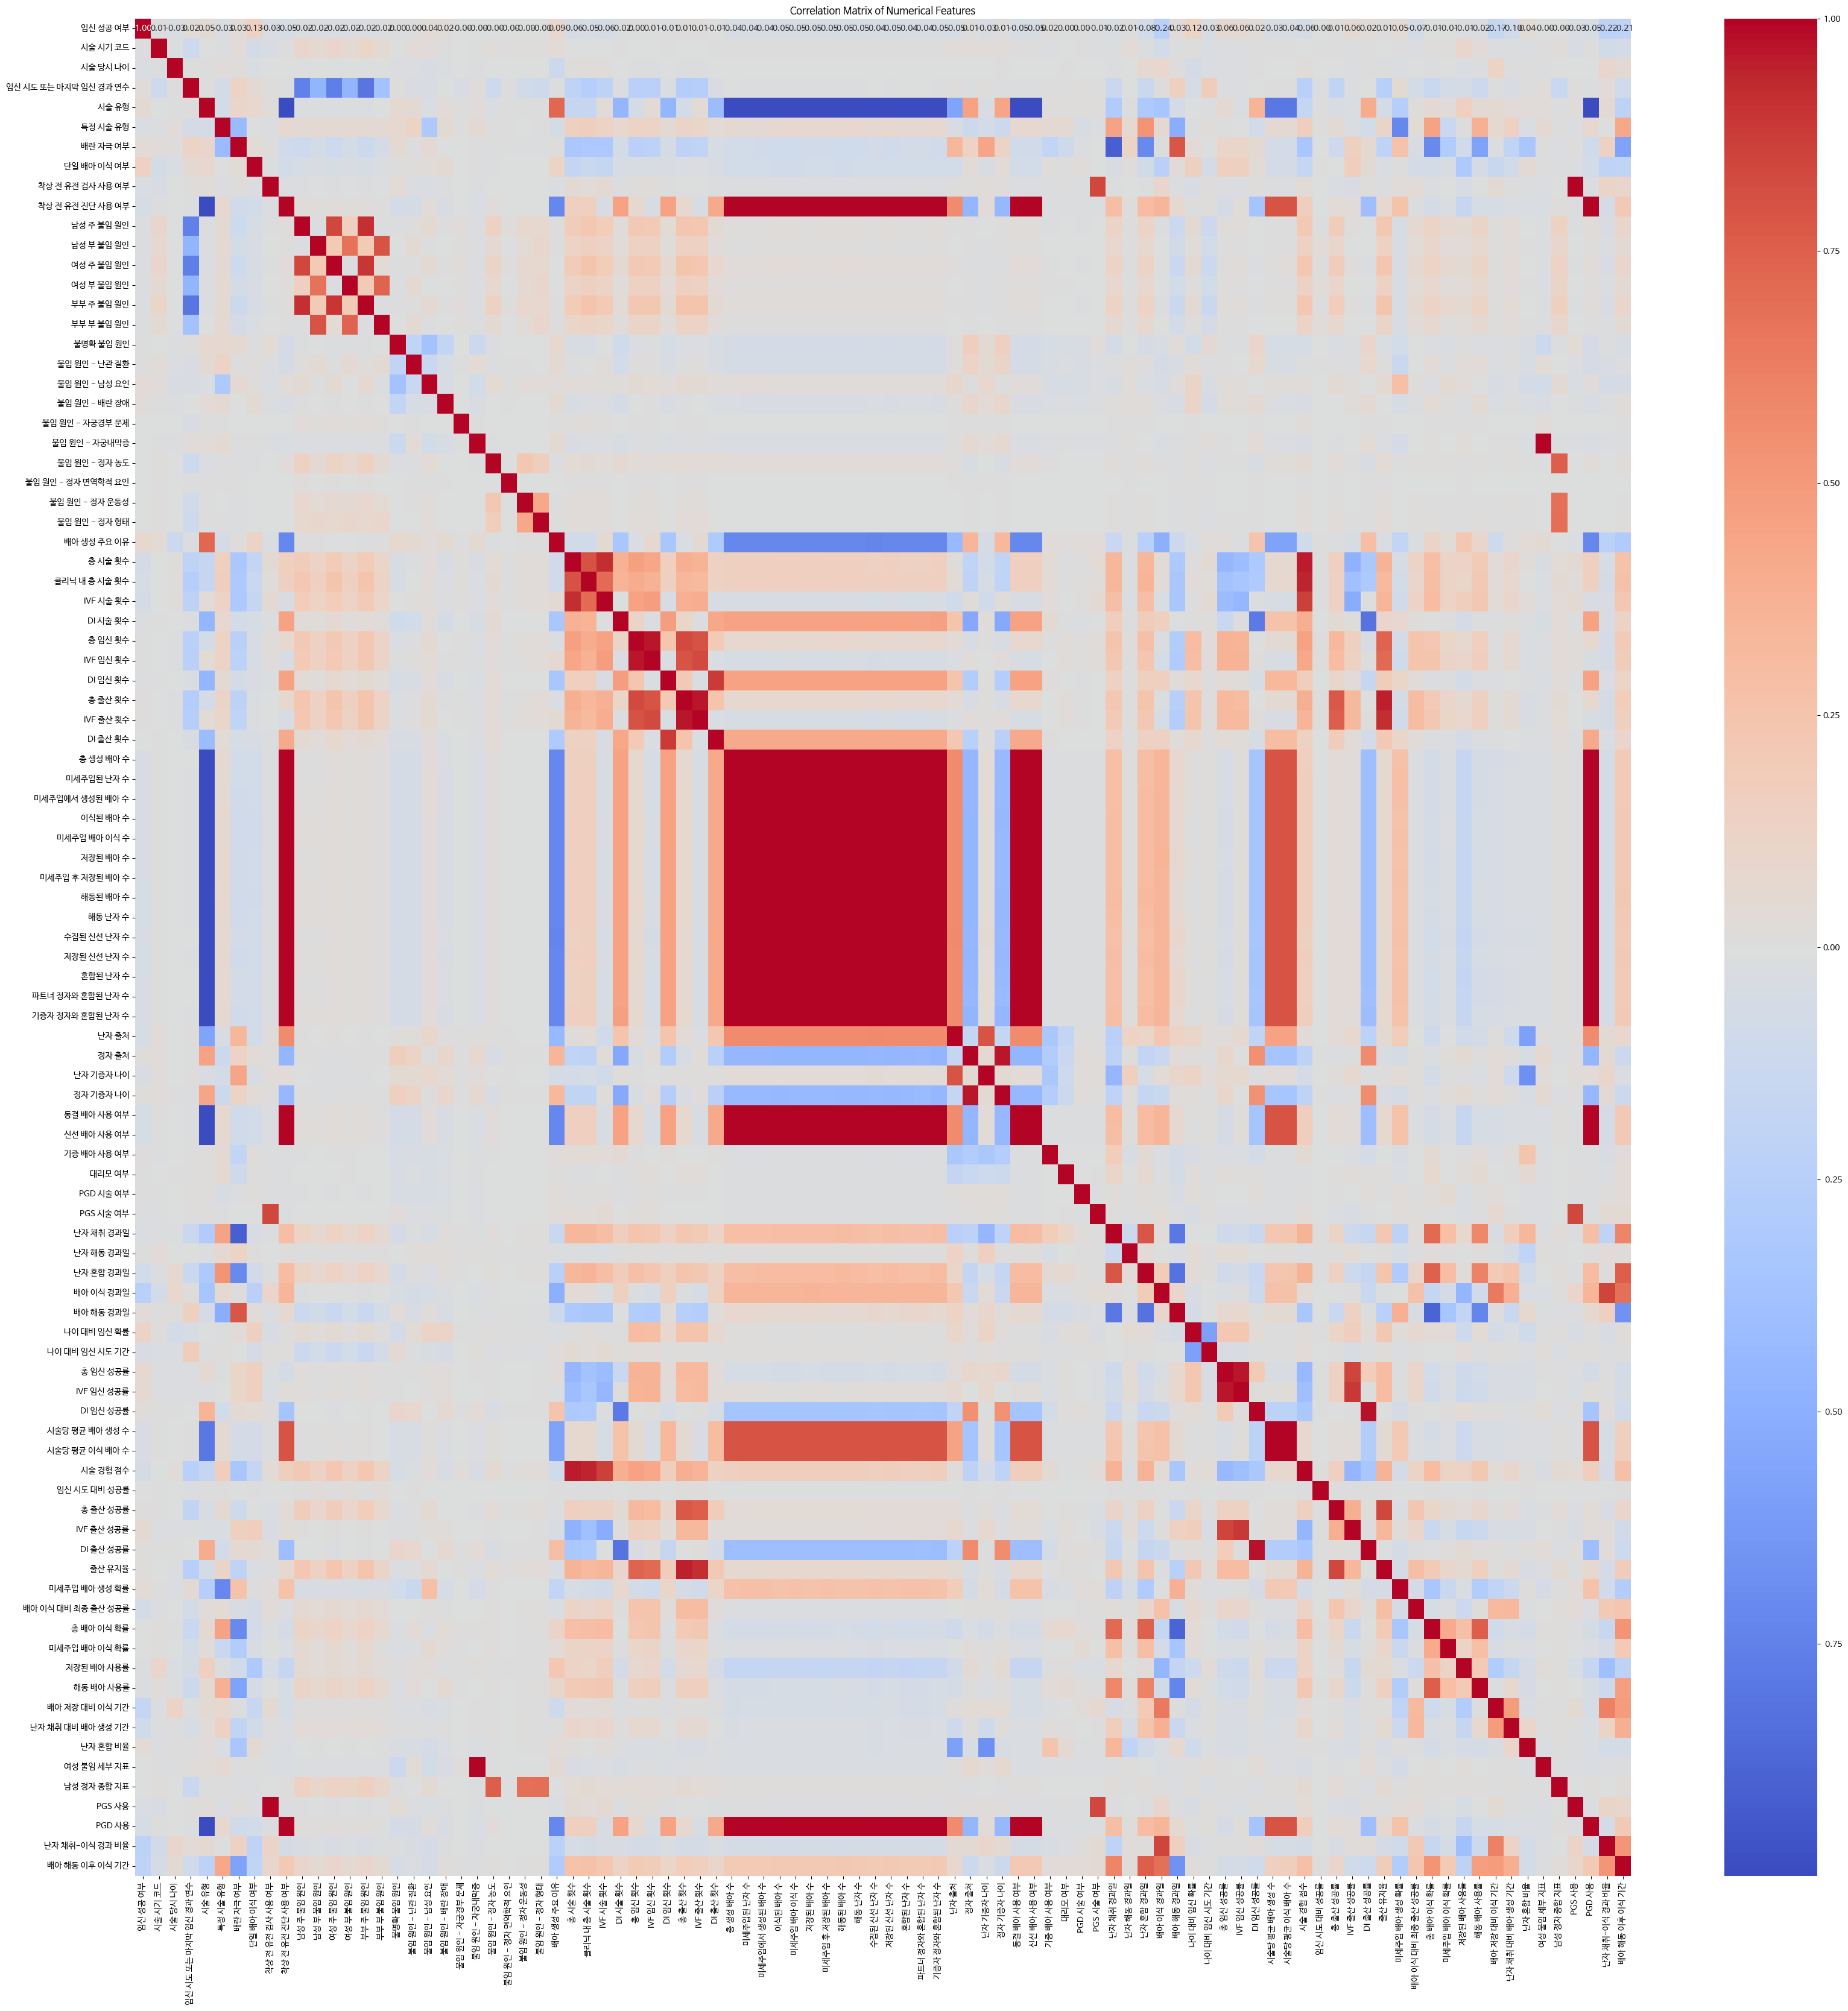

In [8]:
from utils.ft_generator import feature_engineering
df_train = feature_engineering(pre_train)
df_test = feature_engineering(pre_test)

vis_numeric_corr_matrix(df_train)

In [9]:
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)

시술 시기 코드                 0.0
시술 당시 나이                 0.0
임신 시도 또는 마지막 임신 경과 연수    0.0
시술 유형                    0.0
특정 시술 유형                 0.0
                        ... 
PGD 사용                   0.0
배란유도_0                   0.0
배란유도_1                   0.0
난자 채취-이식 경과 비율           0.0
배아 해동 이후 이식 기간           0.0
Length: 96, dtype: float64


In [10]:
train['대리모 여부'].value_counts()

대리모 여부
0.0    249011
1.0      1049
Name: count, dtype: int64

In [11]:
# Nan Inf Detect
from utils.EDA import find_inf_nan_columns

find_inf_nan_columns(df_train)

{'inf_col': [], 'nan_col': []}

In [12]:
# NaN 값이 있는 행
df_train[df_train.isna().any(axis=1)]

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,남성 주 불임 원인,...,난자 채취 대비 배아 생성 기간,난자 혼합 비율,여성 불임 세부 지표,남성 정자 종합 지표,PGS 사용,PGD 사용,배란유도_0,배란유도_1,난자 채취-이식 경과 비율,배아 해동 이후 이식 기간


### Feature selection

In [13]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
cat_features

[]

### Modeling

In [25]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']

<class 'pandas.core.frame.DataFrame'>
Index: 260439 entries, 0 to 256350
Data columns (total 95 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술 시기 코드               260439 non-null  int64  
 1   시술 당시 나이               260439 non-null  int64  
 2   임신 시도 또는 마지막 임신 경과 연수  260439 non-null  float64
 3   시술 유형                  260439 non-null  int64  
 4   특정 시술 유형               260439 non-null  int64  
 5   배란 자극 여부               260439 non-null  int64  
 6   단일 배아 이식 여부            260439 non-null  float64
 7   착상 전 유전 검사 사용 여부       260439 non-null  float64
 8   착상 전 유전 진단 사용 여부       260439 non-null  float64
 9   남성 주 불임 원인             260439 non-null  int64  
 10  남성 부 불임 원인             260439 non-null  int64  
 11  여성 주 불임 원인             260439 non-null  int64  
 12  여성 부 불임 원인             260439 non-null  int64  
 13  부부 주 불임 원인             260439 non-null  int64  
 14  부부 부 불임 원인             260439 non-null  i

#### 일반

In [15]:
# Data split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
X_test = df_test

print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)
print('X_test.shape:', X_test.shape)

X_train.shape: (208351, 95)
X_val.shape: (52088, 95)
y_train.shape: (208351,)
y_val.shape: (52088,)
X_test.shape: (91512, 96)


In [16]:
from utils.metric import print_evaluation_metrics, evaluate_model

# # 모델 정의
cat_model = CatBoostClassifier(
    iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
    subsample=0.8, colsample_bylevel=0.8, random_strength=10,
    loss_function='Logloss', eval_metric='AUC', verbose=100
)

xgb_model = XGBClassifier(
    n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
    gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
    reg_lambda=1.0, verbosity=1
)

lgbm_model = LGBMClassifier(
    n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
    min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, verbosity=1
)

ensemble_model = VotingClassifier(
    estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model)],
    voting='soft', weights=[1, 1, 1]
)

# # 모델 학습
# cat_model.fit(X_train, y_train)
# xgb_model.fit(X_train, y_train)
# lgbm_model.fit(X_train, y_train)
# ensemble_model.fit(X_train, y_train)


# print("------ CatBoost ------")
# print_evaluation_metrics(cat_model, y_val, X_val)
# print("------ XGBoost ------")
# print_evaluation_metrics(xgb_model, y_val, X_val)
# print("------ LightGBM ------")
# print_evaluation_metrics(lgbm_model, y_val, X_val)
# print("------ Ensemble ------ ")
# print_evaluation_metrics(ensemble_model, y_val, X_val)

#### Stratified K-Fold 

In [24]:
X.info

<bound method DataFrame.info of         시술 시기 코드  시술 당시 나이  임신 시도 또는 마지막 임신 경과 연수  시술 유형  특정 시술 유형  배란 자극 여부  \
0              6         0                  999.0      1         5         1   
1              5         5                  999.0      1         5         0   
2              3         0                  999.0      1        16         1   
3              2         1                  999.0      1         5         1   
4              3         0                  999.0      1         5         1   
...          ...       ...                    ...    ...       ...       ...   
256346         5         0                  999.0      1         5         1   
256347         5         2                  999.0      1         5         1   
256348         3         1                  999.0      1         5         1   
256349         6         2                  999.0      1         5         1   
256350         4         1                  999.0      1        16         0   

       

In [17]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']

In [18]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']}

k_fold_models = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 정의
    k_fold_model = CatBoostClassifier(
        iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
        subsample=0.8, colsample_bylevel=0.8, random_strength=10,
        loss_function='Logloss', eval_metric='AUC', verbose=100
    )
    # 모델 학습 (한 번의 fit 과정)
    for model in [k_fold_model]:
        model.fit(X_train, y_train)
    
    k_fold_models.append(model)
    # 평가
    for model_name, model in zip(metrics.keys(), [k_fold_model]):
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")
metrics

===== Fold 1 =====
0:	total: 60.6ms	remaining: 42.4s
100:	total: 1.51s	remaining: 8.94s
200:	total: 3s	remaining: 7.46s
300:	total: 4.4s	remaining: 5.84s
400:	total: 5.84s	remaining: 4.36s
500:	total: 7.4s	remaining: 2.94s
600:	total: 8.99s	remaining: 1.48s
699:	total: 10.5s	remaining: 0us
===== Fold 2 =====
0:	total: 15ms	remaining: 10.5s
100:	total: 1.52s	remaining: 9.04s
200:	total: 3s	remaining: 7.46s
300:	total: 4.39s	remaining: 5.82s
400:	total: 5.82s	remaining: 4.34s
500:	total: 7.32s	remaining: 2.91s
600:	total: 8.84s	remaining: 1.46s
699:	total: 10.3s	remaining: 0us
===== Fold 3 =====
0:	total: 14.6ms	remaining: 10.2s
100:	total: 1.45s	remaining: 8.59s
200:	total: 2.88s	remaining: 7.16s
300:	total: 4.33s	remaining: 5.74s
400:	total: 6.33s	remaining: 4.72s
500:	total: 8.04s	remaining: 3.19s
600:	total: 9.66s	remaining: 1.59s
699:	total: 11.9s	remaining: 0us
===== Fold 4 =====
0:	total: 15.6ms	remaining: 10.9s
100:	total: 1.5s	remaining: 8.9s
200:	total: 3.01s	remaining: 7.48s
3

{'CatBoost': [{'Accuracy': 0.7446436799262786,
   'Precision': 0.5404947475432057,
   'Recall': 0.11779911373707533,
   'F1 Score': 0.19343884543084106,
   'ROC AUC Score': 0.7365816711241401},
  {'Accuracy': 0.7439717401320841,
   'Precision': 0.5355896720167481,
   'Recall': 0.11336779911373708,
   'F1 Score': 0.1871266609776911,
   'ROC AUC Score': 0.737180886643045},
  {'Accuracy': 0.7453348180003072,
   'Precision': 0.549407114624506,
   'Recall': 0.11292466765140324,
   'F1 Score': 0.18734301292654537,
   'ROC AUC Score': 0.7418232677048346},
  {'Accuracy': 0.7451812317616342,
   'Precision': 0.5490842490842491,
   'Recall': 0.11070083450262166,
   'F1 Score': 0.18425419457931289,
   'ROC AUC Score': 0.7427098698529988},
  {'Accuracy': 0.7448307639142204,
   'Precision': 0.5455876968143537,
   'Recall': 0.11004431314623338,
   'F1 Score': 0.18314793190338638,
   'ROC AUC Score': 0.7425628112531887}]}

### Prediction

In [21]:
def mean_ID_extract(df_test:pd.DataFrame):
    df_test['probability'] = df_test.groupby('ID')['probability'].transform('mean')
    df_test_unique = df_test.drop_duplicates(subset=['ID'], keep='first').reset_index(drop=True)
    return df_test_unique

def max_ID_extract(df_test:pd.DataFrame):
    df_test['probability'] = df_test.groupby('ID')['probability'].transform('max')
    df_test_unique = df_test.drop_duplicates(subset=['ID'], keep='first').reset_index(drop=True)
    return df_test_unique



In [22]:
from utils.EDA import vis_prob_barchart
# 평가 지표 평균 출력
print("===== 앙상블 결합 (MAX) =====")
for idx, model in enumerate(k_fold_models):
    pred_proba = model.predict_proba(df_test.drop(columns = 'ID'))[:, 1]
    X_test['probability'] = pred_proba
    
    pred_proba_max = max_ID_extract(X_test)['probability']
    test[f'probability_{idx+1}'] = pred_proba_max

# test에 probability_1 ~ probability_5 컬럼이 있을 때
pred_proba = test[[
    'probability_1',
    'probability_2',
    'probability_3',
    'probability_4',
    'probability_5'
]].mean(axis=1)


pred_proba

===== 앙상블 결합 (MAX) =====


0        0.001232
1        0.001604
2        0.146657
3        0.111317
4        0.496412
           ...   
90062    0.002013
90063    0.248011
90064    0.340857
90065    0.230868
90066    0.001443
Length: 90067, dtype: float64

### Submission

In [32]:
SUBMISSION_DATA_PATH = os.getenv('SUBMISSION_DATA_PATH')
sample_submission = pd.read_csv(SUBMISSION_DATA_PATH)
sample_submission['probability'] = pred_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}.csv')
print(f"save path : {save_path}")
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

save path : ./log/submission/20250211_010937.csv


,ID,probability
0,TEST_00000,0.001356
1,TEST_00001,0.001437
2,TEST_00002,0.146433
3,TEST_00003,0.112666
4,TEST_00004,0.497357


In [20]:
# 확인용
submission = pd.read_csv(save_path)

In [21]:
submission


,ID,probability
0,TEST_00000,0.001503
1,TEST_00001,0.001814
2,TEST_00002,0.166926
3,TEST_00003,0.117691
4,TEST_00004,0.520112
...,...,...
90062,TEST_90062,0.002013
90063,TEST_90063,0.270886
90064,TEST_90064,0.434710
90065,TEST_90065,0.270420
